https://freedium.cfd/medium.com/@kridtapon/cmo-meets-mass-index-a-new-duo-in-algorithmic-trading-bae64a7a888a

In [1]:
# libraries
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# functions
def calculate_cmo(df, period):
    """
    Calculate the Chande Momentum Oscillator (CMO) for a given DataFrame.

    The Chande Momentum Oscillator (CMO) is a technical momentum indicator developed by Tushar Chande.
    It measures the relative strength of recent gains versus recent losses over a specified period,
    providing values between -100 and +100. Positive values indicate upward momentum, negative values
    indicate downward momentum, and extreme values (above +50 or below -50) may signal overbought or
    oversold conditions. The CMO is used to identify trend strength and potential market reversals.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least a 'Close' price column.
    period : int
        The number of periods to use for the CMO calculation.

    Returns
    -------
    pandas.Series
        The CMO values for the given period.
    """
    diff = df['Close'].diff()
    gains = diff.where(diff > 0, 0).rolling(window=period).sum()
    losses = -diff.where(diff < 0, 0).rolling(window=period).sum()
    cmo = (gains - losses) / (gains + losses) * 100
    return cmo

def calculate_mass_index(df, period):
    """
    Calculate the Mass Index (MI) for a given DataFrame.

    The Mass Index (MI) is a technical analysis indicator developed by Donald Dorsey.
    It is designed to identify potential trend reversals by measuring the range between
    high and low prices over a specified period. The MI does not indicate the direction
    of the trend, but rather signals when a trend reversal may be likely due to price range expansion.
    A common signal is generated when the Mass Index rises above a certain threshold (often 27)
    and then falls below another threshold (often 26.5).

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least 'High' and 'Low' price columns.
    period : int
        The number of periods to use for the MI calculation.

    Returns
    -------
    pandas.Series
        The Mass Index values for the given period.
    """
    high_low_range = df['High'] - df['Low']
    ema_high_low = high_low_range.ewm(span=period).mean()
    mass_index = (high_low_range / ema_high_low).rolling(window=period).sum()
    return mass_index

In [3]:
# parameters
symbol = 'PM'
start_date = '2019-01-01'
end_date = '2025-01-01'
cmo_period = 14
mi_period = 25
cmo_range = range(5, 51)
mi_range = range(5, 51)

In [4]:
# Download historical data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)
df['CMO'] = calculate_cmo(df, cmo_period)
df['MassIndex'] = calculate_mass_index(df, mi_period)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


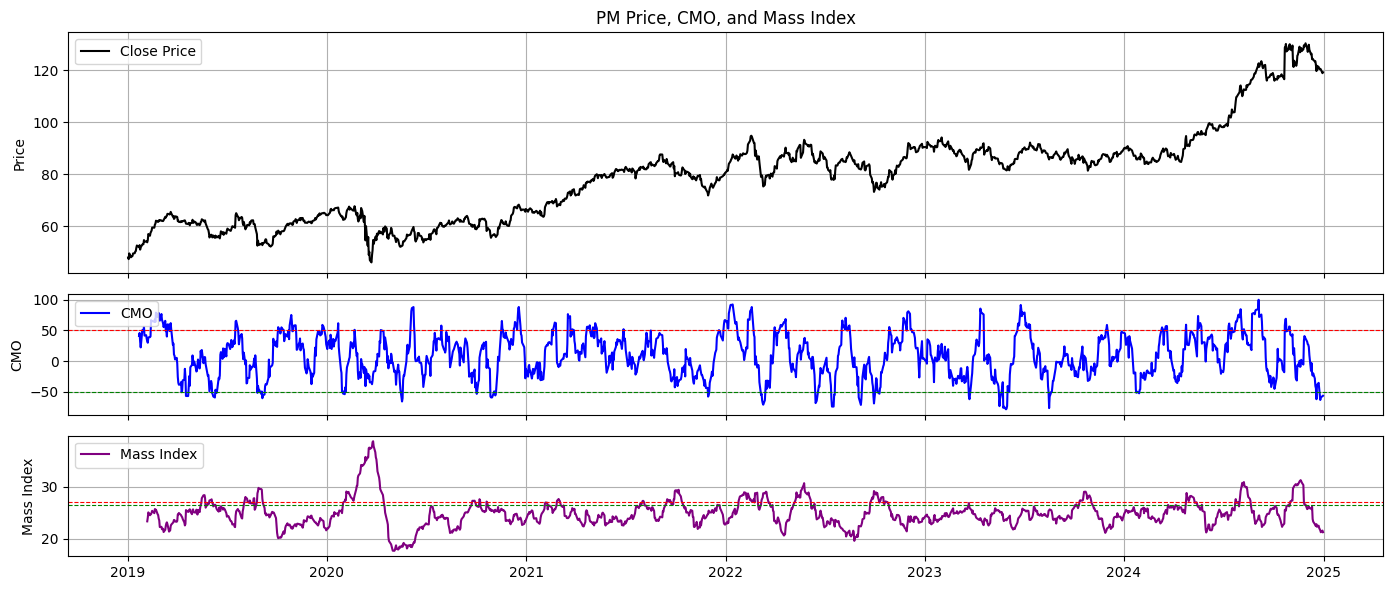

In [5]:
# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
# Price
axes[0].plot(df.index, df['Close'], label='Close Price', color='black')
axes[0].set_ylabel('Price')
axes[0].legend(loc='upper left')
axes[0].set_title(f'{symbol} Price, CMO, and Mass Index')
axes[0].grid(True)  # Add grid
# CMO
axes[1].plot(df.index, df['CMO'], label='CMO', color='blue')
axes[1].axhline(50, color='red', linestyle='--', linewidth=0.8)
axes[1].axhline(-50, color='green', linestyle='--', linewidth=0.8)
axes[1].set_ylabel('CMO')
axes[1].legend(loc='upper left')
axes[1].grid(True)  # Add grid
# Mass Index
axes[2].plot(df.index, df['MassIndex'], label='Mass Index', color='purple')
axes[2].axhline(27, color='red', linestyle='--', linewidth=0.8)
axes[2].axhline(26.5, color='green', linestyle='--', linewidth=0.8)
axes[2].set_ylabel('Mass Index')
axes[2].legend(loc='upper left')
axes[2].grid(True)  # Add grid
plt.tight_layout()
plt.show()


In [6]:
# Running a Grid Search (Brute Force Testing)
results = pd.DataFrame(index=cmo_range, columns=mi_range)
# Grid search
for cmo_p in tqdm(cmo_range, desc="Optimizing CMO"):
    for mi_p in mi_range:
        data = df.copy()
        data['CMO'] = calculate_cmo(data, cmo_p)
        data['MI'] = calculate_mass_index(data, mi_p)
        data['Buy_Signal'] = (data['CMO'] > 0) & (data['MI'] < data['MI'].shift(30))
        data['Sell_Signal'] = (data['CMO'] < 0) & (data['MI'] > data['MI'].shift(30))
        data_test = data[(data.index.year >= 2020) & (data.index.year <= 2025)]
        entries = data_test['Buy_Signal'].shift(1).astype('boolean').fillna(False).to_numpy(dtype=bool)
        exits = data_test['Sell_Signal'].shift(1).astype('boolean').fillna(False).to_numpy(dtype=bool)
        try:
            pf = vbt.Portfolio.from_signals(
                close=data_test['Open'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001,
                slippage=0.002,
                freq='D'
            )
            results.loc[cmo_p, mi_p] = pf.total_return()
        except Exception:
            results.loc[cmo_p, mi_p] = np.nan
# Convert to float
results = results.astype(float)

Optimizing CMO: 100%|██████████| 46/46 [00:24<00:00,  1.85it/s]


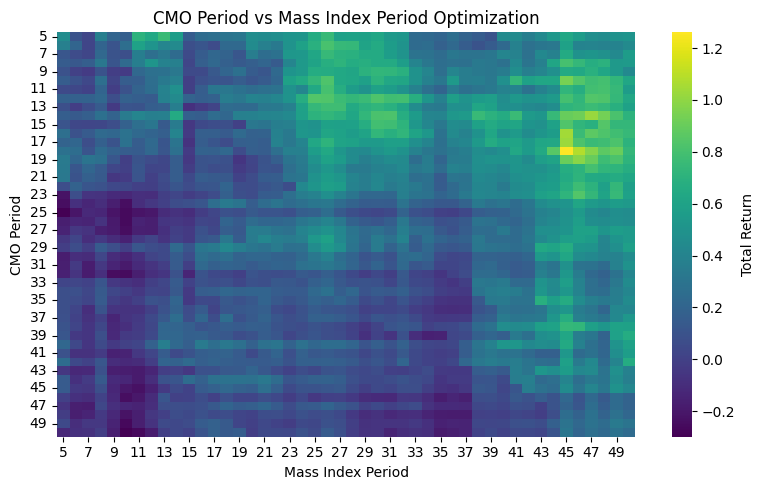

In [7]:
# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(results, annot=False, fmt=".2%", cmap="viridis", cbar_kws={'label': 'Total Return'})
plt.title("CMO Period vs Mass Index Period Optimization")
plt.xlabel("Mass Index Period")
plt.ylabel("CMO Period")
plt.tight_layout()
plt.show()

In [8]:
# Best parameters
best_cmo = results.stack().idxmax()[0]
best_mi = results.stack().idxmax()[1]
best_return = results.loc[best_cmo, best_mi]
print(f"Best CMO Period: {best_cmo}, Best MI Period: {best_mi}, Total Return: {best_return:.2%}")

Best CMO Period: 18, Best MI Period: 45, Total Return: 126.07%


In [9]:
# Backtesting with The Best Parameter
# Calculate Chande Momentum Oscillator (CMO)
df['CMO'] = calculate_cmo(df, 18)
# Calculate Mass Index (MI)
df['MI'] = calculate_mass_index(df, 45)
# Define Entry and Exit signals based on CMO and Mass Index Strategy
# Buy Signal: CMO crosses above zero, and MI is decreasing from a high value
df['Buy_Signal'] = (df['CMO'] > 0) & (df['MI'] < df['MI'].shift(30))
# Sell Signal: CMO crosses below zero, and MI is increasing from a low value
df['Sell_Signal'] = (df['CMO'] < 0) & (df['MI'] > df['MI'].shift(30))
# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
# Shift entries and exits to next bar
shifted_entries = df['Buy_Signal'].shift(1).astype("boolean").fillna(False).to_numpy()
shifted_exits = df['Sell_Signal'].shift(1).astype("boolean").fillna(False).to_numpy()
# Create portfolio using 'Open' prices
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)
# Display performance metrics
print(portfolio.stats())
# Plot equity curve
portfolio.plot().show()

Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  226067.453458
Total Return [%]                              126.067453
Benchmark Return [%]                           84.663241
Max Gross Exposure [%]                             100.0
Total Fees Paid                              4112.336676
Max Drawdown [%]                               16.077222
Max Drawdown Duration                  536 days 00:00:00
Total Trades                                          13
Total Closed Trades                                   13
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   53.846154
Best Trade [%]                                 44.272101
Worst Trade [%]                